# Homework 5: Taming Text

"Did you said *personal emails*, Madame the Secretary of State ?"

# 0. Import the libraries, Read the data and check its form

We import the usual libraries. Note the library *WordCloud* or *nltk* which are going to be very useful for us in this exercise.

In [1]:
# Usual imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

Let's define the path of the emails data:

In [2]:
# Some constants
mailPath = 'hillary-clinton-emails/Emails.csv'

And we read them:

In [3]:
# Read data
df = pd.read_csv(mailPath, sep=',')
# Columns available
df.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

We observe that the data are pretty complex, and not all the information will be useful for us in this homework. Let's observe specifically the columns *ExtractedSubject*, *ExtractedBodyText* and *RawText*.

In [4]:
df[['ExtractedSubject', 'ExtractedBodyText', 'RawText']].head(6)

,ExtractedSubject,ExtractedBodyText,RawText
0,FW: Wow,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,Re: Chris Stevens,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,FVV: Cairo Condemnation - Final,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We observe that some *ExtractedSubject* and *ExtractedBodyText* entries are filled with NaN. We will see their impact bellow.

# 1. Word Cloud Generation

Let's try to create a WordCloud image to observe which are the words most used by the Secretary of State in her emails. We construct the WordCloud on the unmodified data first.

Let's define a function that concatenate the emails text into one single string in order to respect wordcloud input requires:

In [5]:
def concatenate_emails(dataFrame):
    text_tuple = list(dataFrame.ExtractedBodyText) + list(dataFrame.ExtractedSubject)
    
    text = " ".join(str(s) for s in text_tuple)
    text = text.replace('\n', ' ')
    text = text.replace('\'', '"')

    return text

We need also to define a function that create and plot correctly a wordcloud:

In [6]:
def plot_wordcloud(text, max_font_size=None, background_color=None, max_words=None, mask=None, stopwords=None):
    wordcloud = WordCloud(max_font_size=max_font_size)
    wordcloud.generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [7]:
text_raw = concatenate_emails(df)

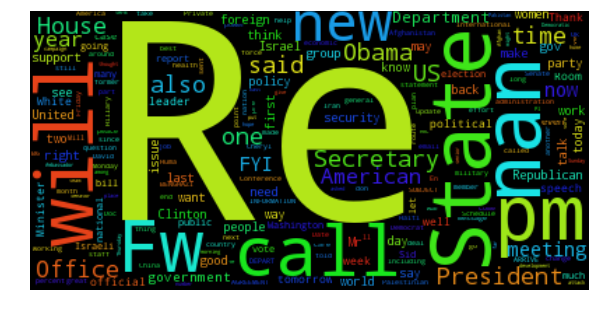

In [8]:
plot_wordcloud(text_raw)

We can have multiple comments on this image: First, we observe that some relevant words seem to appears many times as the words *State*, *Obama* or *Secretary*. This is good and not really surprising coming from the email of the Secretary of State during Obama mandat. However, we also see some unrelevant words as for example: *Re* which is generated automatically by the mailbox when one responds to an email, and the word *nan* which is coming from the DataFrame to inform us that no data are available for a specific entry. Thus, we need to clean and pre-process the text in order to get rid of all this useless and wrong information.

For the cleaning process, we are going to go trough the following steps:
* **Tokenization**
* **Stopword removal**
* **Lemmatization**
* **Stemming**

## 1.1 Tokenization

First, let's tokenize the emails text we have. Here is the [Wikipedia](https://en.wikipedia.org/wiki/Tokenization) definition of tokenization for Data and lexical Analysis purpose:

> *In lexical analysis, tokenization is the process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing such as parsing or text mining.*

We tokenize each words of the text in order to remove the irrelevant ones in further process, i.e *Stopword removal*.

In [10]:
# Tokenization
tokens = nltk.regexp_tokenize(text_raw, pattern='\w+')

# Normalization
tokens = [t.lower() for t in tokens]

# Removing the numbers
tokens = [t for t in tokens if t.isdigit() == False]

tokens[:10]

['nan', 'b6', 'thursday', 'march', 'pm', 'h', 'latest', 'how', 'syria', 'is']

We observe that we could successfully separate each word in different tokens, but we still need to remove the irrelevant words with the *Stopword removal* process.

## 1.2 Stopword removal

The role of this step is to remove from the tokens all the words that do not bring us more interesting information and thus pollute the analysed text. First, let's define which words are considerated as stopword.

First we download the already predefined stopwords from the *nltk* library:

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidrivollet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidrivollet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Then, we can add to the list, the stopword specifically defined for emails, i.e *re*, *to*, *pm* for examples.

In [14]:
emails_stop_words = ['nan', 're', 'fw', 'fwd', 'fvv', 'fyi', 'fm', 'h','pm','docx', 'n\'t', 'sent', 'from', 'to', 'subject', 'cc', 'bcc', 'attachments', 'html', 'php']

stop_words = set(stopwords.words('english'))
stop_words.update(emails_stop_words)
print(stop_words)

{'through', 'yourselves', 'should', 'some', 'doesn', 'hasn', 'why', 'those', 'where', 'docx', 'same', 'most', 'until', 'and', 'from', 'sent', 'he', 'fyi', 'm', 'being', 'won', 'has', 'ours', 'as', 'about', 'fw', 'each', 's', 'into', 'then', 'himself', 'its', 'but', 'our', 'own', 'this', 'while', 'nor', 'your', 'whom', 'was', 'fm', 'php', 'here', 'over', 'yours', 'between', 'bcc', 'a', 'doing', 'on', "n't", 'fwd', 'wouldn', 'down', 'ourselves', 'theirs', 'h', 'shan', 'we', 'herself', 'y', 'hadn', 'mightn', 'does', 'with', 'what', 'didn', 'the', 'only', 'cc', 'html', 'such', 'them', 'couldn', 'against', 'they', 'subject', 'during', 'above', 'in', 'at', 'i', 'now', 'hers', 'myself', 'him', 'of', 'fvv', 'can', 'don', 'under', 'no', 'how', 'be', 'their', 'having', 'than', 'haven', 'weren', 'am', 'out', 'up', 'had', 'his', 'an', 'further', 'so', 'wasn', 'again', 'it', 'who', 'aren', 'not', 'pm', 'if', 'were', 'will', 'which', 'after', 'did', 'these', 'any', 'isn', 'all', 'other', 'me', 'nan'

Let's now get rid of theses stopwords in the tokens previously computed. We note that some tokens have been correctly removed.

In [15]:
tokens_cleaned = [t for t in tokens if t not in stop_words]
tokens_cleaned[:10]

['b6',
 'thursday',
 'march',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 'sid',
 'hrc',
 'memo']

We can remark as well that there is still some *noisy words* in the tokens. For example, if we check the tokens with a length smaller than 3, we observe that we get multiple noisy tokens that have not been removed. 

In [16]:
token_short = [t for t in tokens_cleaned if len(t) < 3]
token_short[:10]

['b6', '4g', 'u', 'f', 'b6', '4g', 'b6', 'b6', '4g', 'op']

In [17]:
len(token_short)

11718

Therefore, we can remove as well theses useless words from our list of tokens.

In [18]:
tokens_cleaned = [t for t in tokens_cleaned if len(t) > 2]
tokens_cleaned[:10]

['thursday',
 'march',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 'sid',
 'hrc',
 'memo',
 'syria']

## 1.3 Lemmatization

In order to obtain even better result, we can also *lemmatize* our tokens. The lemmatization process consists in transforming and regrouping the words of a similar origin to its easiest form. For examples, the words *boys* and *boy* or *similarities* and *similarity*, previously stored in four different tokens, will now be only stored in two, say *boy* and *similarity*. For doing the lemmatization, we will use a predefine function from the *nltk* library.

In [30]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
tokens_lemmatized = [wnl.lemmatize(t) for t in tokens_cleaned]

With theses processing, let's rebuild a wordcloud image and observe what are the notable differences so far. First, we need to define a function to concatenate the tokens together. 

(The function is very simple but it is clearer to define it as a function, because we are going to use the same code multiple times in this exercise.)

In [26]:
def concatenate_tokens(tokens):
    text = " ".join(t for t in tokens)
    return text

In [27]:
text_lemmatized = concatenate_tokens(tokens_lemmatized)

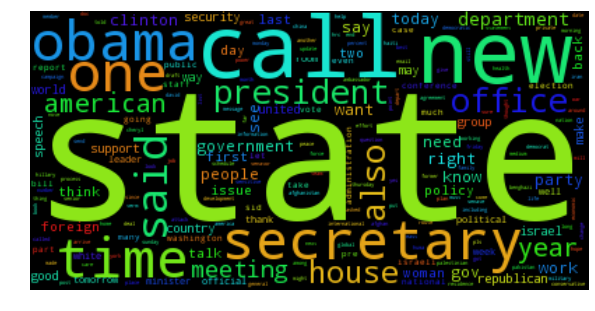

In [28]:
plot_wordcloud(text_lemmatized)

As we expected, we can observe now that all the *noisy words* previously seen in the wordcloud, as *'nan'*, *'Re'*, *'Fw'* or *'pm'* , have been removed, which let place to much more relevant words as *'state'*, *'call'* or *'secretary'* for examples.

## 1.4 Stemming

One other processing that can improve the performances is to do stemming on the tokens. The stemming process delete the sufixes of some words in order to regroupe words from the same family into one unique token. For example, *automate(s)*, *automatic*, *automation* will all be reduced to *automat*. It reduces the words to their roots. Thus, the token *example* will become *exampl*.

In [31]:
from nltk.stem.porter import *

stemmer = PorterStemmer()
tokens_stemmed = [stemmer.stem(t) for t in tokens_lemmatized]

We can observe now what are the impacts of the stemming processus, by looking at the wordcloud image generated with the new tokens.

In [33]:
text_stemmed = concatenate_tokens(tokens_stemmed)

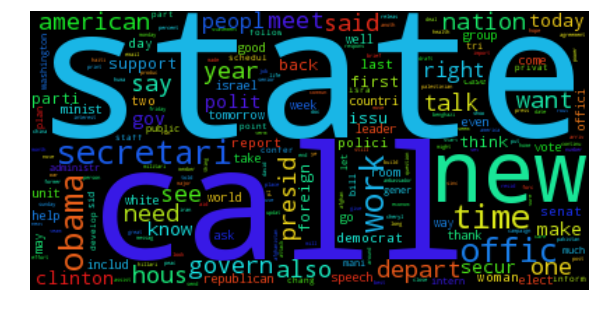

In [35]:
plot_wordcloud(text_stemmed)

The first comment we can make on this new image is that the word *call* has now more importance than on the previous image. This is due to the fact that words like *calling* or *called* are now regroup into a single *call* token. We also can see the impact of the stemming process by looking at the tokens *office* and *secretary* that became respectively *offic* and *secretari*.

The processus seems to have been benifical for the results because we can see now more relevant tokens appearing as *govern* or *republican*. In the contrary, not interesting tokens like *one* or *time* have less importance.

# 2. Popularity of Counties

In [ ]:
# TODO

# 3. Topic Modelling

In [ ]:
# TODO

# 4. Communication Graph (BONUS)

In [ ]:
# TODO